In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget

In [ ]:
from __future__ import annotations

import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from network_utils import (
    create_56bus,
    create_RX_from_net,
    read_load_data
)

from cbc import CBCProjection, cp_triangle_norm_sq
from robust_voltage_control import (
    VoltPlot,
    np_triangle_norm,
    robust_voltage_control
)

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# hide top and right splines on plots
# plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

## Calculate minimum q-limits needed to keep voltage within bounds

Answer: ±0.23757973725624573

In [ ]:
def calc_qlims(
        p: np.ndarray, qe: np.ndarray, X: np.ndarray, R: np.ndarray,
        v_lims: tuple[float, float], v_sub: float,
        eta: float, eps: float, norm2: float = 0.0) -> np.ndarray:
    """Calculates minimum-inf-norm values for q^c_t to ensure feasibility.

    Args
    - p: np.array, shape [T, n], active power injection (MW)
    - qe: np.array, shape [T, n], exogenous reactive power injection (MVar)
    - v_lims: tuple of float, (v_min, v_max), squared voltage magnitude limits (kV^2)
    - X: np.array, shape [n, n], line parameters for reactive power injection
    - R: np.array, shape [n, n], line parameters for active power injection
    - v_sub: float, fixed squared voltage magnitude at substation (kV^2)
    - eta: float, noise bound (kV^2)
    - eps: float, robustness buffer (kV^2)
    - norm2: float, weight for 2-norm in objective

    Returns
    - qcts: np.ndarray, shape [n, T-1]
    """
    assert p.shape == qe.shape
    T, n = qe.shape
    vpars = qe @ X + p @ R + v_sub  # shape [T, n]

    v_min, v_max = v_lims
    v_lb = v_min + eta + eps
    v_ub = v_max - (eta + eps)
    qcts = []

    block = 69  # T = 14421 is perfectly divisible by 69
    qct = cp.Variable([block, n])
    vpars_param = cp.Parameter([block, n])

    if norm2 == 0:
        obj = cp.Minimize(cp.sum(cp.norm(qct, p='inf', axis=1)))
    else:
        obj = cp.Minimize(cp.sum(cp.norm(qct, p='inf', axis=1) + norm2 * cp.norm(qct, p=2, axis=1)))

    constrs = [
        v_lb <= qct @ X + vpars_param,
        qct @ X + vpars_param <= v_ub]
    prob = cp.Problem(objective=obj, constraints=constrs)

    qcts = []
    for t in tqdm(range(0, T, block)):
        if t + block > T:
            ts = list(range(t, T)) + [T-1] * (block - (T-t))
        else:
            ts = slice(t, t+block)
        vpars_param.value = vpars[ts]
        prob.solve(solver=cp.MOSEK, warm_start=True)
        assert prob.status == 'optimal'
        qcts.append(np.array(qct.value))  # make a copy
    qcts = np.concatenate(qcts, axis=1)
    return qcts

In [ ]:
net = create_56bus()
R, X = create_RX_from_net(net, noise=0)
p, qe = read_load_data()  # in MW and MVar
T, n = p.shape

In [ ]:
v_min, v_max = (11.4**2, 12.6**2)  # +/-5%, units kV^2
v_nom = 12**2  # nominal squared voltage magnitude, units kV^2
v_sub = v_nom  # fixed squared voltage magnitude at substation, units kV^2

In [ ]:
qcts = calc_qlims(p=p, qe=qe, X=X, R=R, v_lims=(v_min, v_max), v_sub=v_sub,
                  eta=0, eps=0, norm2=0.1)
print(f'min q_i: {np.min(qcts):.4f}, max q_i: {np.max(qcts):.4f}')

In [ ]:
qcts = calc_qlims(p=p, qe=qe, X=X, R=R, v_lims=(v_min, v_max), v_sub=v_sub,
                  eta=0, eps=0)
print(f'min q_i: {np.min(qcts):.4f}, max q_i: {np.max(qcts):.4f}')
# min q_i: -0.2376, max q_i: 0.2376

In [ ]:
qcts = calc_qlims(p=p, qe=qe, X=X, R=R, v_lims=(v_min, v_max), v_sub=v_sub,
                  eta=8.65, eps=0.1, norm2=0.1)  # TODO: re-run
print(f'min q_i: {np.min(qcts):.4f}, max q_i: {np.max(qcts):.4f}')
# min q_i: -0.4601, max q_i: 0.1700

In [ ]:
qcts = calc_qlims(p=p, qe=qe, X=X, R=R, v_lims=(v_min, v_max), v_sub=v_sub,
                  eta=8.65, eps=0.1, norm2=0.1)  # TODO: re-run
print(f'min q_i: {np.min(qcts):.4f}, max q_i: {np.max(qcts):.4f}')
# min q_i: -0.4549, max q_i: 0.4374

## Plot $\left\|\hat{X}-X\right\|_\triangle$ as a function of line-parameter noise

In [3]:
net = create_56bus()
_, X_true = create_RX_from_net(net, noise=0)
norm_true = np_triangle_norm(X_true)
print(f'||X||△ = {norm_true}')  # 166.7369736441201

nsamples = 50
noises = np.arange(0.01, 1, 0.01)
norms = np.zeros([len(noises), nsamples])
for i, noise in enumerate(tqdm(noises)):
    for j in range(nsamples):
        _, Xhat = create_RX_from_net(net, noise=noise, check_pd=True, seed=None)
        norms[i,j] = np_triangle_norm(X_true - Xhat)

||X||△ = 166.7369736441201


0it [00:00, ?it/s]

[Text(0, 0.5, '$||\\hat{X}-X|| / ||X||$')]

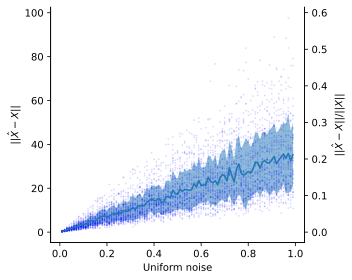

In [4]:
norms_mean = norms.mean(axis=1)
norms_std = norms.std(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(5,4), tight_layout=True)
ax.plot(noises, norms_mean)
ax.fill_between(noises, norms_mean - norms_std, norms_mean + norms_std, alpha=0.5)
for j in range(nsamples):
    ax.scatter(noises, norms[:,j], s=1, color='b', alpha=0.1)
ax.set(xlabel='Uniform noise', ylabel='$||\hat{X}-X||$')

ax2 = ax.twinx()
y_min, y_max = ax.get_ylim()
ax2.set_ylim(y_min / norm_true, y_max / norm_true)
ax2.set(ylabel='$||\hat{X}-X|| / ||X||$')
plt.show()

## Plot $\left\|\hat{X}-X\right\|_\triangle$ for modified graphs

In [3]:
import copy
import seaborn as sns

In [4]:
net_orig = create_56bus()
_, X_true = create_RX_from_net(net_orig, noise=0)
norm_true = np_triangle_norm(X_true)
print(f'||X||△ = {norm_true}')  # 166.7369736441201

nsamples = 50
modifies = [None, 'perm', 'linear', 'rand']
data = []
for j in tqdm(range(nsamples)):
    for noise in [0.5, 1.0]:
        for i, modify in enumerate(modifies):
            net = copy.deepcopy(net_orig)
            _, Xhat = create_RX_from_net(net, noise=noise, modify=modify, check_pd=True, seed=None)
            norm = np_triangle_norm(X_true - Xhat)
            data.append([modify, norm, noise, j])

norms_df = pd.DataFrame(data=data, columns=['modify', 'norm', 'noise', 'sample'])
norms_df['modify'].fillna('None', inplace=True)

||X||△ = 166.7369736441201


  0%|          | 0/50 [00:00<?, ?it/s]

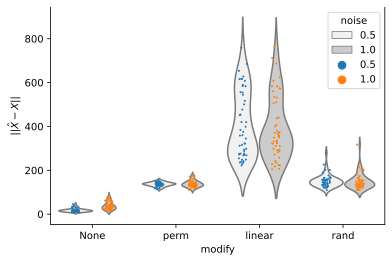

In [5]:
ax = sns.violinplot(x='modify', y='norm', hue='noise', data=norms_df, inner=None, color='.8')
ax = sns.stripplot(x='modify', y='norm', hue='noise', size=2, dodge=True, data=norms_df)
ax.set(ylabel='$||\hat{X}-X||$')
plt.show()